<a href="https://colab.research.google.com/github/SashaMalysheva/fastai/blob/main/Image.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq fastbook

In [2]:
import fastbook
fastbook.setup_book()
#hide
from fastbook import *
from fastai.vision.widgets import *
from fastai.data.all import *

# Images

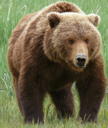

In [3]:
ims = ['http://3.bp.blogspot.com/-S1scRCkI3vY/UHzV2kucsPI/AAAAAAAAA-k/YQ5UzHEm9Ss/s1600/Grizzly%2BBear%2BWildlife.jpg']
dest = 'images/grizzly.jpg'
download_url(ims[0], dest)
im = Image.open(dest)
im.to_thumb(128,128)


In [4]:
key = os.environ.get('AZURE_SEARCH_KEY', '8ffff961b1e045c08966889069d69b33')

This seems to have worked nicely, so let's use fastai's download_images to download all the URLs for each of our search terms. We'll put each in a separate folder

In [5]:
bear_types = 'grizzly','black','teddy'
path = Path('bears')
if not path.exists():
    path.mkdir()
for o in bear_types:
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f'{o} bear')
    download_images(dest, urls=results.attrgot('contentUrl'))


Our folder has image files, as we'd expect:

In [6]:
fns = get_image_files(path)
fns

(#514) [Path('bears/black/00000124.jpg'),Path('bears/black/00000142.jpg'),Path('bears/black/00000010.jpg'),Path('bears/black/00000137.jpg'),Path('bears/black/00000033.jpg'),Path('bears/black/00000144.jpg'),Path('bears/black/00000092.jpg'),Path('bears/black/00000100.jpg'),Path('bears/black/00000138.jpg'),Path('bears/black/00000109.jpg')...]

To remove all the failed images, you can use unlink on each of them. Note that, like most fastai functions that return a collection, verify_images returns an object of type L, which includes the map method. This calls the passed function on each element of the collection:

In [7]:
failed = verify_images(fns)
failed

(#6) [Path('bears/teddy/00000057.jpeg'),Path('bears/teddy/00000104.png'),Path('bears/teddy/00000058.jpg'),Path('bears/teddy/00000010.png'),Path('bears/teddy/00000116.jpg'),Path('bears/teddy/00000042.jpeg')]

In [8]:
failed.map(Path.unlink);

In this case, our independent variables are images, and our dependent variables are the categories (type of bear) for each image.

get_image_files function takes a path, and returns a list of all of the images in that path 

parent_label is a function provided by fastai that simply gets the name of the folder a file is in.

In [9]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

This command has given us a DataBlock object. This is like a template for creating a DataLoaders. We still need to tell fastai the actual source of our data—in this case, the path where the images can be found

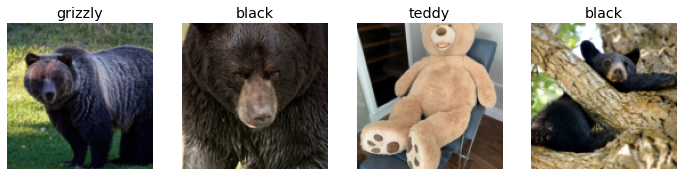

In [10]:
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

### Resize Differnet mode

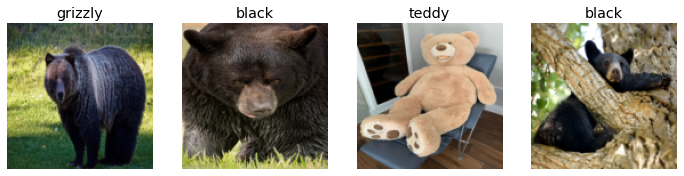

In [11]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

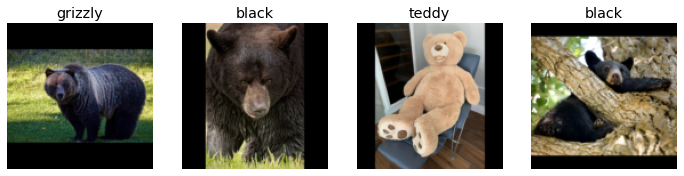

In [12]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Instead, what we normally do in practice is to randomly select part of the image, and crop to just that part.

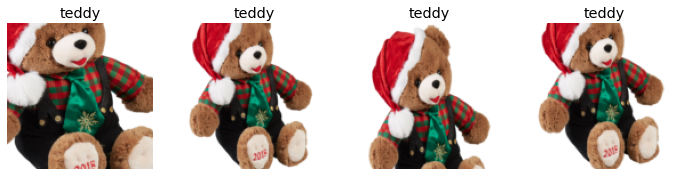

In [13]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

## Data Augmentation

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


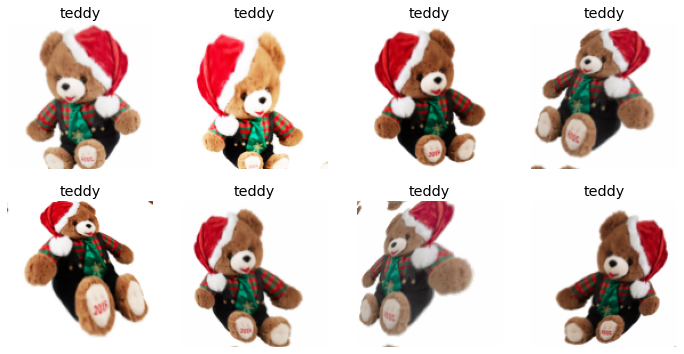

In [14]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)


## Classification

We don't have a lot of data for our problem (150 pictures of each sort of bear at most), so to train our model, we'll use RandomResizedCrop with an image size of 224 px, which is fairly standard for image classification, and default aug_transforms

In [15]:
bears = bears.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = bears.dataloaders(path)

learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.360835,0.122641,0.029703,01:51


epoch,train_loss,valid_loss,error_rate,time
0,0.153671,0.080202,0.039604,02:26
1,0.091704,0.104691,0.029703,02:20
2,0.064643,0.167745,0.039604,02:18
3,0.057337,0.155957,0.029703,02:22


Now let's see whether the mistakes the model is making are mainly thinking that grizzlies are teddies (that would be bad for safety!), or that grizzlies are black bears, or something else. To visualize this, we can create a confusion matrix:

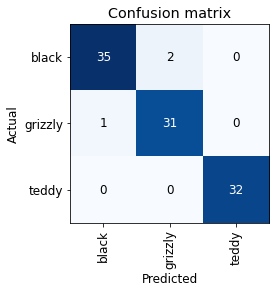

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

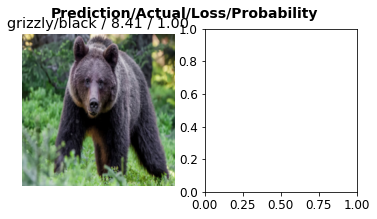

In [20]:
interp.plot_top_losses(2, nrows=1)

fastai includes a handy GUI for data cleaning called ImageClassifierCleaner that allows you to choose a category and the training versus validation set and view the highest-loss images (in order), along with menus to allow images to be selected for removal or relabeling

In [21]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
#hide
# for idx in cleaner.delete(): cleaner.fns[idx].unlink()
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

### Save and load model
When you call export, fastai will save a file called "export.pkl":

In [22]:
learn.export()
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

load

## Online inference


In [41]:
learn_inf = load_learner(path/'export.pkl')

In [42]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [43]:
#if you dont want to choose
btn_upload = SimpleNamespace(data = ['images/grizzly.jpg'])

In [44]:
img = PILImage.create(btn_upload.data[-1])

In [45]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [50]:
pred,pred_idx,probs = learn_inf.predict(img)
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: grizzly; Probability: 1.0000')

In [51]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [52]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [53]:
btn_upload = widgets.FileUpload()

In [54]:
VBox([widgets.Label('Select your bear!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

###Turning Your Notebook into a Real App

In [40]:
!pip install voila
!jupyter serverextension enable --sys-prefix voila

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 111 kB 55.9 MB/s 
     |████████████████████████████████| 557 kB 55.9 MB/s 
     |████████████████████████████████| 397 kB 54.6 MB/s 
     |████████████████████████████████| 130 kB 38.0 MB/s 
     |████████████████████████████████| 79 kB 6.2 MB/s 
     |████████████████████████████████| 53 kB 1.6 MB/s 
     |████████████████████████████████| 428 kB 55.8 MB/s 
  Attempting uninstall: tornado
    Found existing installation: tornado 5.1.1
    Uninstalling tornado-5.1.1:
      Successfully uninstalled tornado-5.1.1
  Attempting uninstall: jupyter-client
    Found existing installation: jupyter-client 5.3.5
    Uninstalling jupyter-client-5.3.5:
      Successfully uninstalled jupyter-client-5.3.5
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: pip's dependency resolver does

Enabling: voila
- Writing config: /usr/etc/jupyter
    - Validating...
Error loading server extension voila
      X is voila importable?
